In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import lstm #
from lstm import ModelHyperparameters, TrainingConfig # Import the dataclasses
from data_prep import (
    DataInputConfig,
    TransformationConfig,
    FeatureEngineeringConfig,
    ScalingConfig,
    SequenceConfig,
    prepare_weather_data
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
df = pd.read_csv('solar_weather.csv')
df

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


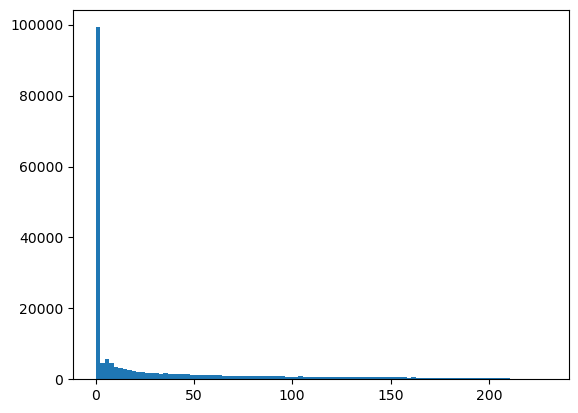

In [3]:
rad = df['GHI']

plt.hist(rad, bins=100)
plt.show()




## LSTM NN

In [36]:
target_col_original = 'GHI' 

input_cfg = DataInputConfig(
    target_col_original_name=target_col_original
)

transform_cfg = TransformationConfig(
    use_log_transform=False, 
    use_power_transform=True, 
    use_piecewise_transform_target=False, 
    min_target_threshold_initial=None, 
    clip_original_target_before_power_transform=False, 
    original_target_clip_lower_percentile=10.0, 
    original_target_clip_upper_percentile=90.0, 
    min_radiation_floor_before_power_transform=0.0, 
    min_radiation_for_log=0.001, 
    clip_log_transformed_target=True, 
    log_clip_lower_percentile=1.0, 
    log_clip_upper_percentile=99.0 
)

feature_cfg = FeatureEngineeringConfig(
    use_solar_elevation_proxy=True, 
    feature_selection_mode='basic' 
   
)

scaling_cfg = ScalingConfig(
    standardize_features=False 
)

sequence_cfg = SequenceConfig(
    window_size=24, 
    test_size=0.15, 
    val_size_from_train_val=0.25 / (1.0 - 0.15) if (1.0 - 0.15) > 0 else 0.25
)


In [37]:
try:
    X_train, X_val, X_test, y_train, y_val, y_test, \
    scalers, feature_cols, full_transform_details = prepare_weather_data(
        df_input=df,
        input_cfg=input_cfg,
        transform_cfg=transform_cfg,
        feature_cfg=feature_cfg,
        scaling_cfg=scaling_cfg,
        sequence_cfg=sequence_cfg
    )

    logging.info("Data preparation successful using v2.")
    logging.info(f"X_train shape: {X_train.shape}, feature_cols: {feature_cols}")
    logging.info(f"Full transform details: {full_transform_details}")

except Exception as e:
    logging.error(f"Error during data preparation: {e}", exc_info=True)

2025-06-06 19:04:14,972 - INFO - Starting weather data preparation pipeline v2.
2025-06-06 19:04:14,981 - INFO - Applied column renames: {'GHI': 'Radiation', 'temp': 'Temperature', 'pressure': 'Pressure', 'humidity': 'Humidity', 'wind_speed': 'WindSpeed', 'clouds_all': 'Cloudcover', 'rain_1h': 'Rain', 'snow_1h': 'Snow', 'weather_type': 'WeatherType', 'Time': 'Timestamp', 'hour': 'hour', 'month': 'month', 'dayLength': 'dayLength', 'isSun': 'isSun', 'SunlightTime/daylength': 'SunlightTime/daylength'}
2025-06-06 19:04:15,032 - INFO - Sorted DataFrame by 'Timestamp'.
2025-06-06 19:04:15,123 - INFO - Engineered 'SolarElevation' feature.
2025-06-06 19:04:15,140 - INFO - Applying Yeo-Johnson Power Transform to 'Radiation'.
2025-06-06 19:04:15,224 - INFO - Engineered 'Radiation_is_low' feature with threshold -0.0000 (based on 'Radiation_yj').
2025-06-06 19:04:15,224 - INFO - Including low target indicator 'Radiation_is_low' in features.
2025-06-06 19:04:15,224 - INFO - Final selected features 

In [6]:
import optuna
import torch
import itertools
from sklearn.metrics import r2_score
device = torch.device('cpu')
def objective(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.3, step=0.1)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
    clip_grad_norm = trial.suggest_categorical('clip_grad_norm', [1.0, 1.5])
    value_multiplier = trial.suggest_categorical('value_multiplier', [0.1, 0.15, 0.2])
    scheduler_type = trial.suggest_categorical('scheduler_type', ['plateau', 'cosine'])
    loss_type = trial.suggest_categorical('loss_type', ['mse', 'value_aware'])
    mse_weight = trial.suggest_categorical('mse_weight', [0.5, 0.7, 0.9])
    mape_weight = trial.suggest_categorical('mape_weight', [0.5, 0.3, 0.1])
    
    # Create model hyperparameters
    model_params = ModelHyperparameters(
        input_dim=len(feature_cols),
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=1,
        dropout_prob=dropout_prob
    )
    
    # Create training config
    train_cfg = TrainingConfig(
        epochs=10,  # Just 10 epochs for initial screening
        batch_size=32,
        learning_rate=learning_rate,
        scheduler_type=scheduler_type,
        loss_type=loss_type,
        mse_weight=mse_weight,
        mape_weight=mape_weight,
        value_multiplier=value_multiplier,
        clip_grad_norm=clip_grad_norm,
        T_max_cosine=10
    )
    
    # Create and train model
    model = lstm.WeatherLSTM(model_params)
    model.fit(
        X_train, y_train, X_val, y_val,
        train_cfg
    )
    
    # Evaluate model
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_val, dtype=torch.float32).to(device))
        predictions = predictions.cpu().numpy()
    
    # Calculate metrics
    r2 = r2_score(y_val, predictions)
    print(f"Trial {trial.number}: hidden_dim={hidden_dim}, num_layers={num_layers}, "
          f"dropout_prob={dropout_prob}, learning_rate={learning_rate:.6f}, "
          f"clip_grad_norm={clip_grad_norm}, value_multiplier={value_multiplier}, R²={r2:.4f}")
    
    return r2  # Return metric to maximize



# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1)

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
print(f"Best value (R²): {study.best_value:.4f}")

[I 2025-06-06 13:30:02,516] A new study created in memory with name: no-name-e148536f-7954-4b7f-8f3f-956da308111d
2025-06-06 13:30:02,543 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0002261941085323473, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.5, scheduler_type='plateau', T_max_cosine=10, loss_type='value_aware', mse_weight=0.7, mape_weight=0.1, value_multiplier=0.2)
2025-06-06 13:30:02,545 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0002598789875083444, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=10, loss_type='value_aware', mse_weight=0.7, mape_weight=0.1, value_multiplier=0.2)
2025-06-06 13:30:02,546 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.000788812710

Trial 5: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000278, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9858


[I 2025-06-06 13:49:18,412] Trial 7 finished with value: 0.9853234925897977 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00038512408752468816, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'plateau', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 5 with value: 0.9858260585202799.
2025-06-06 13:49:18,415 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0006454323715222569, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.5, scheduler_type='plateau', T_max_cosine=10, loss_type='value_aware', mse_weight=0.9, mape_weight=0.5, value_multiplier=0.1)


Trial 7: hidden_dim=64, num_layers=2, dropout_prob=0.3, learning_rate=0.000385, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9853


2025-06-06 13:49:37,078 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0770 - ValLoss: 0.0611 | Scaled Metrics: ValRMSE: 0.1324, ValR²: 0.9827, ValCappedMAPE: 10.29%, ValMAE: 0.0765
2025-06-06 13:49:42,048 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0260 - ValLoss: 0.0188 | Scaled Metrics: ValRMSE: 0.1107, ValR²: 0.9879, ValCappedMAPE: 9.33%, ValMAE: 0.0565
2025-06-06 13:49:45,913 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.1479 - ValLoss: 0.1052 | Scaled Metrics: ValRMSE: 0.2157, ValR²: 0.9542, ValCappedMAPE: 15.93%, ValMAE: 0.1357
2025-06-06 13:50:01,385 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.0949 - ValLoss: 0.0520 | Scaled Metrics: ValRMSE: 0.2279, ValR²: 0.9488, ValCappedMAPE: 14.19%, ValMAE: 0.1095
2025-06-06 13:50:25,288 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0365 - ValLoss: 0.0194 | Scaled Metrics: ValRMSE: 0.1149, ValR²: 0.9870, ValCappedMAPE: 9.32%, ValMAE: 0.0544
2025-06-06 13:52:25,306 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0764 - ValLoss: 0.0642 | Scaled Metrics: ValRMSE: 0.1353, ValR²

Trial 10: hidden_dim=64, num_layers=3, dropout_prob=0.1, learning_rate=0.000591, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9779


2025-06-06 13:58:26,338 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.1425 - ValLoss: 0.0988 | Scaled Metrics: ValRMSE: 0.1991, ValR²: 0.9610, ValCappedMAPE: 15.37%, ValMAE: 0.1279
2025-06-06 13:58:26,340 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 13:58:30,249] Trial 4 finished with value: 0.9609567041982794 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.3, 'learning_rate': 0.00016192714395110982, 'clip_grad_norm': 1.0, 'value_multiplier': 0.15, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.5}. Best is trial 5 with value: 0.9858260585202799.
2025-06-06 13:58:30,254 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.0008591760211183285, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=10, loss_type='value_aware', mse_weight=0.7, mape_weight=0.5, value_multiplier

Trial 4: hidden_dim=64, num_layers=3, dropout_prob=0.3, learning_rate=0.000162, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9610


2025-06-06 14:00:16,702 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.0840 - ValLoss: 0.0276 | Scaled Metrics: ValRMSE: 0.1661, ValR²: 0.9728, ValCappedMAPE: 11.90%, ValMAE: 0.0871
2025-06-06 14:00:41,301 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1766 - ValLoss: 0.0943 | Scaled Metrics: ValRMSE: 0.1748, ValR²: 0.9699, ValCappedMAPE: 14.27%, ValMAE: 0.1144
2025-06-06 14:02:08,472 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0337 - ValLoss: 0.0206 | Scaled Metrics: ValRMSE: 0.1170, ValR²: 0.9865, ValCappedMAPE: 9.94%, ValMAE: 0.0661
2025-06-06 14:02:08,717 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0274 - ValLoss: 0.0148 | Scaled Metrics: ValRMSE: 0.1216, ValR²: 0.9854, ValCappedMAPE: 11.17%, ValMAE: 0.0787
2025-06-06 14:02:37,263 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0947 - ValLoss: 0.0683 | Scaled Metrics: ValRMSE: 0.1361, ValR²: 0.9818, ValCappedMAPE: 10.94%, ValMAE: 0.0791
2025-06-06 14:03:01,825 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0220 - ValLoss: 0.0163 | Scaled Metrics: ValRMSE: 0.1277, ValR

Trial 14: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000775, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9872


2025-06-06 14:18:15,788 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0776 - ValLoss: 0.0648 | Scaled Metrics: ValRMSE: 0.1220, ValR²: 0.9853, ValCappedMAPE: 10.71%, ValMAE: 0.0800
2025-06-06 14:18:15,790 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 14:18:18,889] Trial 15 finished with value: 0.9853454439596366 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.0008591760211183285, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.7, 'mape_weight': 0.5}. Best is trial 14 with value: 0.9871587874124298.
2025-06-06 14:18:18,893 - INFO - LSTM Training started. Device: cpu, Training Config: TrainingConfig(epochs=10, batch_size=32, learning_rate=0.00013855199032868207, patience=10, factor=0.5, min_lr=1e-06, weight_decay=1e-05, clip_grad_norm=1.5, scheduler_type='plateau', T_max_cosine=10, loss_type='value_aware', mse_weight=0.9, mape_weight=0.5, value_multipli

Trial 15: hidden_dim=64, num_layers=2, dropout_prob=0.1, learning_rate=0.000859, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9853


2025-06-06 14:19:45,317 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0830 - ValLoss: 0.0578 | Scaled Metrics: ValRMSE: 0.1074, ValR²: 0.9886, ValCappedMAPE: 9.36%, ValMAE: 0.0575
2025-06-06 14:19:48,082 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1388 - ValLoss: 0.0713 | Scaled Metrics: ValRMSE: 0.2898, ValR²: 0.9173, ValCappedMAPE: 23.17%, ValMAE: 0.2070
2025-06-06 14:20:06,328 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0322 - ValLoss: 0.0190 | Scaled Metrics: ValRMSE: 0.1126, ValR²: 0.9875, ValCappedMAPE: 9.27%, ValMAE: 0.0575
2025-06-06 14:20:12,124 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0219 - ValLoss: 0.0190 | Scaled Metrics: ValRMSE: 0.1195, ValR²: 0.9859, ValCappedMAPE: 8.20%, ValMAE: 0.0504
2025-06-06 14:20:18,265 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0215 - ValLoss: 0.0142 | Scaled Metrics: ValRMSE: 0.1190, ValR²: 0.9861, ValCappedMAPE: 8.81%, ValMAE: 0.0527
2025-06-06 14:21:48,208 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0184 - ValLoss: 0.0127 | Scaled Metrics: ValRMSE: 0.1125, ValR²: 

Trial 6: hidden_dim=128, num_layers=1, dropout_prob=0.2, learning_rate=0.000260, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9880


2025-06-06 14:27:29,266 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.2871 - ValLoss: 0.1509 | Scaled Metrics: ValRMSE: 0.2548, ValR²: 0.9361, ValCappedMAPE: 17.39%, ValMAE: 0.1357
2025-06-06 14:28:01,598 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0520 - ValLoss: 0.0296 | Scaled Metrics: ValRMSE: 0.1621, ValR²: 0.9741, ValCappedMAPE: 14.30%, ValMAE: 0.1152
2025-06-06 14:28:13,933 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1198 - ValLoss: 0.0426 | Scaled Metrics: ValRMSE: 0.2065, ValR²: 0.9580, ValCappedMAPE: 15.76%, ValMAE: 0.1345
2025-06-06 14:28:30,050 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0810 - ValLoss: 0.0643 | Scaled Metrics: ValRMSE: 0.1228, ValR²: 0.9852, ValCappedMAPE: 9.98%, ValMAE: 0.0683
2025-06-06 14:28:52,872 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0218 - ValLoss: 0.0210 | Scaled Metrics: ValRMSE: 0.1159, ValR²: 0.9868, ValCappedMAPE: 10.22%, ValMAE: 0.0623
2025-06-06 14:29:15,874 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0562 - ValLoss: 0.0324 | Scaled Metrics: ValRMSE: 0.1799, ValR

Trial 18: hidden_dim=64, num_layers=1, dropout_prob=0.3, learning_rate=0.000957, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9812


2025-06-06 14:38:05,937 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.0207 - ValLoss: 0.0188 | Scaled Metrics: ValRMSE: 0.1370, ValR²: 0.9815, ValCappedMAPE: 12.66%, ValMAE: 0.0872
2025-06-06 14:38:29,186 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0480 - ValLoss: 0.0257 | Scaled Metrics: ValRMSE: 0.1478, ValR²: 0.9785, ValCappedMAPE: 12.98%, ValMAE: 0.1018
2025-06-06 14:38:29,187 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 14:38:33,397] Trial 16 finished with value: 0.9784895186852048 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout_prob': 0.3, 'learning_rate': 0.00033690353883345257, 'clip_grad_norm': 1.0, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 6 with value: 0.9880003854056904.


Trial 16: hidden_dim=64, num_layers=2, dropout_prob=0.3, learning_rate=0.000337, clip_grad_norm=1.0, value_multiplier=0.2, R²=0.9785


2025-06-06 14:41:53,603 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0168 - ValLoss: 0.0122 | Scaled Metrics: ValRMSE: 0.1105, ValR²: 0.9880, ValCappedMAPE: 11.08%, ValMAE: 0.0750
2025-06-06 14:41:57,919 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0568 - ValLoss: 0.0487 | Scaled Metrics: ValRMSE: 0.1352, ValR²: 0.9820, ValCappedMAPE: 10.38%, ValMAE: 0.0773
2025-06-06 14:42:00,570 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0304 - ValLoss: 0.0247 | Scaled Metrics: ValRMSE: 0.1207, ValR²: 0.9857, ValCappedMAPE: 9.84%, ValMAE: 0.0682
2025-06-06 14:42:01,272 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0694 - ValLoss: 0.0692 | Scaled Metrics: ValRMSE: 0.1707, ValR²: 0.9713, ValCappedMAPE: 13.24%, ValMAE: 0.1107
2025-06-06 14:43:21,098 - INFO - LSTM Epoch 3/10 - TrainLoss: 0.1223 - ValLoss: 0.0809 | Scaled Metrics: ValRMSE: 0.1523, ValR²: 0.9772, ValCappedMAPE: 11.70%, ValMAE: 0.0782
2025-06-06 14:44:37,424 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0783 - ValLoss: 0.0593 | Scaled Metrics: ValRMSE: 0.1179, ValR

Trial 0: hidden_dim=256, num_layers=1, dropout_prob=0.1, learning_rate=0.000226, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9897


2025-06-06 14:45:56,331 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0205 - ValLoss: 0.0195 | Scaled Metrics: ValRMSE: 0.1396, ValR²: 0.9808, ValCappedMAPE: 12.63%, ValMAE: 0.0968
2025-06-06 14:49:37,739 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.1088 - ValLoss: 0.0748 | Scaled Metrics: ValRMSE: 0.1570, ValR²: 0.9757, ValCappedMAPE: 10.26%, ValMAE: 0.0695
2025-06-06 14:50:21,268 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0775 - ValLoss: 0.0776 | Scaled Metrics: ValRMSE: 0.1391, ValR²: 0.9809, ValCappedMAPE: 11.80%, ValMAE: 0.0890
2025-06-06 14:51:01,740 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0151 - ValLoss: 0.0133 | Scaled Metrics: ValRMSE: 0.1151, ValR²: 0.9869, ValCappedMAPE: 10.29%, ValMAE: 0.0672
2025-06-06 14:53:20,232 - INFO - LSTM Epoch 1/10 - TrainLoss: 0.1010 - ValLoss: 0.0420 | Scaled Metrics: ValRMSE: 0.1832, ValR²: 0.9670, ValCappedMAPE: 15.52%, ValMAE: 0.1197
2025-06-06 14:55:11,726 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.1013 - ValLoss: 0.0677 | Scaled Metrics: ValRMSE: 0.1224, Val

Trial 13: hidden_dim=256, num_layers=1, dropout_prob=0.2, learning_rate=0.000645, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9845


2025-06-06 15:01:29,696 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0139 - ValLoss: 0.0100 | Scaled Metrics: ValRMSE: 0.1002, ValR²: 0.9901, ValCappedMAPE: 8.98%, ValMAE: 0.0515
2025-06-06 15:04:37,893 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0945 - ValLoss: 0.0589 | Scaled Metrics: ValRMSE: 0.1176, ValR²: 0.9864, ValCappedMAPE: 9.15%, ValMAE: 0.0540
2025-06-06 15:04:53,657 - INFO - LSTM Epoch 2/10 - TrainLoss: 0.0382 - ValLoss: 0.0231 | Scaled Metrics: ValRMSE: 0.1279, ValR²: 0.9839, ValCappedMAPE: 10.43%, ValMAE: 0.0698
2025-06-06 15:06:37,183 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0183 - ValLoss: 0.0188 | Scaled Metrics: ValRMSE: 0.1370, ValR²: 0.9815, ValCappedMAPE: 11.07%, ValMAE: 0.0817
2025-06-06 15:06:59,638 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0148 - ValLoss: 0.0114 | Scaled Metrics: ValRMSE: 0.1069, ValR²: 0.9887, ValCappedMAPE: 10.27%, ValMAE: 0.0679
2025-06-06 15:07:05,858 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0525 - ValLoss: 0.0462 | Scaled Metrics: ValRMSE: 0.1223, ValR²

Trial 17: hidden_dim=256, num_layers=1, dropout_prob=0.3, learning_rate=0.000139, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9856


2025-06-06 15:20:42,584 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0124 - ValLoss: 0.0113 | Scaled Metrics: ValRMSE: 0.1062, ValR²: 0.9889, ValCappedMAPE: 9.44%, ValMAE: 0.0606
2025-06-06 15:24:52,056 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0173 - ValLoss: 0.0124 | Scaled Metrics: ValRMSE: 0.1112, ValR²: 0.9878, ValCappedMAPE: 9.90%, ValMAE: 0.0639
2025-06-06 15:25:03,045 - INFO - LSTM Epoch 4/10 - TrainLoss: 0.0265 - ValLoss: 0.0240 | Scaled Metrics: ValRMSE: 0.1331, ValR²: 0.9825, ValCappedMAPE: 10.07%, ValMAE: 0.0725
2025-06-06 15:25:21,455 - INFO - LSTM Epoch 6/10 - TrainLoss: 0.0144 - ValLoss: 0.0134 | Scaled Metrics: ValRMSE: 0.1157, ValR²: 0.9868, ValCappedMAPE: 10.46%, ValMAE: 0.0680
2025-06-06 15:26:36,911 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0136 - ValLoss: 0.0104 | Scaled Metrics: ValRMSE: 0.1021, ValR²: 0.9897, ValCappedMAPE: 9.61%, ValMAE: 0.0620
2025-06-06 15:26:41,016 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0649 - ValLoss: 0.0522 | Scaled Metrics: ValRMSE: 0.1412, ValR²:

Trial 11: hidden_dim=256, num_layers=2, dropout_prob=0.2, learning_rate=0.000151, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9848


2025-06-06 15:33:22,757 - INFO - LSTM Epoch 5/10 - TrainLoss: 0.0252 - ValLoss: 0.0181 | Scaled Metrics: ValRMSE: 0.1056, ValR²: 0.9890, ValCappedMAPE: 9.39%, ValMAE: 0.0591
2025-06-06 15:34:29,303 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0131 - ValLoss: 0.0113 | Scaled Metrics: ValRMSE: 0.1063, ValR²: 0.9889, ValCappedMAPE: 9.46%, ValMAE: 0.0620
2025-06-06 15:34:33,278 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0641 - ValLoss: 0.0505 | Scaled Metrics: ValRMSE: 0.1318, ValR²: 0.9829, ValCappedMAPE: 11.04%, ValMAE: 0.0826
2025-06-06 15:34:33,318 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0497 - ValLoss: 0.0416 | Scaled Metrics: ValRMSE: 0.1107, ValR²: 0.9879, ValCappedMAPE: 9.94%, ValMAE: 0.0662
2025-06-06 15:34:35,759 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0256 - ValLoss: 0.0232 | Scaled Metrics: ValRMSE: 0.1146, ValR²: 0.9871, ValCappedMAPE: 9.69%, ValMAE: 0.0676
2025-06-06 15:35:48,600 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0113 - ValLoss: 0.0105 | Scaled Metrics: ValRMSE: 0.1024, ValR²: 

Trial 9: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000609, clip_grad_norm=1.0, value_multiplier=0.15, R²=0.9887


2025-06-06 15:41:06,041 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0636 - ValLoss: 0.0527 | Scaled Metrics: ValRMSE: 0.1259, ValR²: 0.9844, ValCappedMAPE: 12.33%, ValMAE: 0.0911
2025-06-06 15:41:06,044 - INFO - LSTM Training complete. Best model state loaded.
2025-06-06 15:41:08,639 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0495 - ValLoss: 0.0442 | Scaled Metrics: ValRMSE: 0.1225, ValR²: 0.9852, ValCappedMAPE: 9.91%, ValMAE: 0.0712
2025-06-06 15:41:08,640 - INFO - LSTM Training complete. Best model state loaded.
2025-06-06 15:41:15,058 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0254 - ValLoss: 0.0222 | Scaled Metrics: ValRMSE: 0.1108, ValR²: 0.9879, ValCappedMAPE: 9.57%, ValMAE: 0.0655
2025-06-06 15:41:15,139 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 15:41:23,760] Trial 2 finished with value: 0.9843936220042768 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.2, 'learning_rate': 0.0007888127100583183, 'clip_grad_norm': 1.5, 'value_multipli

Trial 2: hidden_dim=128, num_layers=3, dropout_prob=0.2, learning_rate=0.000789, clip_grad_norm=1.5, value_multiplier=0.15, R²=0.9844


[I 2025-06-06 15:41:28,099] Trial 8 finished with value: 0.9852202926090459 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00023381471045557772, 'clip_grad_norm': 1.5, 'value_multiplier': 0.1, 'scheduler_type': 'plateau', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 0 with value: 0.9897043692627809.


Trial 8: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000234, clip_grad_norm=1.5, value_multiplier=0.1, R²=0.9852


[I 2025-06-06 15:41:29,643] Trial 1 finished with value: 0.9879110899509564 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00031972458245114137, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'value_aware', 'mse_weight': 0.9, 'mape_weight': 0.1}. Best is trial 0 with value: 0.9897043692627809.


Trial 1: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000320, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9879


2025-06-06 15:42:01,926 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0110 - ValLoss: 0.0098 | Scaled Metrics: ValRMSE: 0.0990, ValR²: 0.9903, ValCappedMAPE: 8.98%, ValMAE: 0.0550
2025-06-06 15:42:01,928 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 15:42:16,131] Trial 12 finished with value: 0.9903428550365022 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.0003346979509052172, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.1}. Best is trial 12 with value: 0.9903428550365022.


Trial 12: hidden_dim=256, num_layers=2, dropout_prob=0.1, learning_rate=0.000335, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9903


2025-06-06 15:43:21,723 - INFO - LSTM Epoch 7/10 - TrainLoss: 0.0236 - ValLoss: 0.0191 | Scaled Metrics: ValRMSE: 0.1125, ValR²: 0.9875, ValCappedMAPE: 9.13%, ValMAE: 0.0606
2025-06-06 15:43:31,185 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0130 - ValLoss: 0.0113 | Scaled Metrics: ValRMSE: 0.1065, ValR²: 0.9888, ValCappedMAPE: 9.15%, ValMAE: 0.0564
2025-06-06 15:45:26,681 - INFO - LSTM Epoch 8/10 - TrainLoss: 0.0229 - ValLoss: 0.0177 | Scaled Metrics: ValRMSE: 0.1045, ValR²: 0.9892, ValCappedMAPE: 9.13%, ValMAE: 0.0591
2025-06-06 15:46:47,064 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0125 - ValLoss: 0.0117 | Scaled Metrics: ValRMSE: 0.1082, ValR²: 0.9885, ValCappedMAPE: 9.38%, ValMAE: 0.0599
2025-06-06 15:47:30,454 - INFO - LSTM Epoch 9/10 - TrainLoss: 0.0226 - ValLoss: 0.0200 | Scaled Metrics: ValRMSE: 0.1153, ValR²: 0.9869, ValCappedMAPE: 9.42%, ValMAE: 0.0654
2025-06-06 15:49:32,246 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0223 - ValLoss: 0.0198 | Scaled Metrics: ValRMSE: 0.1134, ValR²: 

Trial 19: hidden_dim=128, num_layers=3, dropout_prob=0.1, learning_rate=0.000309, clip_grad_norm=1.5, value_multiplier=0.2, R²=0.9873


2025-06-06 15:49:52,414 - INFO - LSTM Epoch 10/10 - TrainLoss: 0.0124 - ValLoss: 0.0117 | Scaled Metrics: ValRMSE: 0.1083, ValR²: 0.9884, ValCappedMAPE: 9.43%, ValMAE: 0.0604
2025-06-06 15:49:52,415 - INFO - LSTM Training complete. Best model state loaded.
[I 2025-06-06 15:50:09,166] Trial 3 finished with value: 0.9884436550492499 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.1, 'learning_rate': 0.00017787909529937818, 'clip_grad_norm': 1.0, 'value_multiplier': 0.1, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.9, 'mape_weight': 0.3}. Best is trial 12 with value: 0.9903428550365022.


Trial 3: hidden_dim=256, num_layers=3, dropout_prob=0.1, learning_rate=0.000178, clip_grad_norm=1.0, value_multiplier=0.1, R²=0.9884
Best parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_prob': 0.1, 'learning_rate': 0.0003346979509052172, 'clip_grad_norm': 1.5, 'value_multiplier': 0.2, 'scheduler_type': 'cosine', 'loss_type': 'mse', 'mse_weight': 0.5, 'mape_weight': 0.1}
Best value (R²): 0.9903


In [38]:

input_dim = len(feature_cols)  # Number of features
hidden_dim = 256
num_layers = 2
output_dim = 1  # Dimension of output
dropout_prob = 0.3

# Create ModelHyperparameters instance
model_params = ModelHyperparameters(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_prob=dropout_prob
)


learning_rate_val = 0.00015
epochs_val = 100
batch_size_val = 32
patience_val = 30
scheduler_type_val = "cosine"
weight_decay_val = 0.0 
clip_grad_norm_val = 1.0
loss_type_val = 'mse'
mse_weight_val = 0.7
mape_weight_val = 0.3 
value_multiplier_val = 0.1

# Create TrainingConfig instance
train_cfg = TrainingConfig(
    epochs=epochs_val,
    batch_size=batch_size_val,
    learning_rate=learning_rate_val,
    patience=patience_val,
    scheduler_type=scheduler_type_val,
    weight_decay=weight_decay_val,
    clip_grad_norm=clip_grad_norm_val,
    loss_type=loss_type_val,
    mse_weight=mse_weight_val,
    mape_weight=mape_weight_val,
    value_multiplier=value_multiplier_val,
    
    # factor and min_lr for ReduceLROnPlateau will use defaults if not specified
    # T_max_cosine for CosineAnnealingLR will default to epochs if None
)

In [39]:
# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu') # More robust device selection

# Use the model_params dataclass for instantiation
model = lstm.WeatherLSTM(model_params=model_params).to(device)


In [40]:

model.transform_info = full_transform_details

# Train the model using the train_cfg dataclass
model.fit(
    X_train, y_train, X_val, y_val,
    train_config=train_cfg, # Pass the TrainingConfig instance
    device=device
)


2025-06-06 19:04:47,981 - INFO - LSTM Training started. Device: mps, Training Config: TrainingConfig(epochs=100, batch_size=32, learning_rate=0.00015, patience=30, factor=0.5, min_lr=1e-06, weight_decay=0.0, clip_grad_norm=1.0, scheduler_type='cosine', T_max_cosine=None, loss_type='mse', mse_weight=0.7, mape_weight=0.3, value_multiplier=0.1)
2025-06-06 19:05:32,761 - INFO - LSTM Epoch 1/100 - TrainLoss: 0.1091 - ValLoss: 0.0433 | Scaled Metrics: ValRMSE: 0.2082, ValR²: 0.9573, ValCappedMAPE: 17.61%, ValMAE: 0.1377
2025-06-06 19:06:15,415 - INFO - LSTM Epoch 2/100 - TrainLoss: 0.0485 - ValLoss: 0.0449 | Scaled Metrics: ValRMSE: 0.2119, ValR²: 0.9558, ValCappedMAPE: 17.47%, ValMAE: 0.1486
2025-06-06 19:06:59,876 - INFO - LSTM Epoch 3/100 - TrainLoss: 0.0361 - ValLoss: 0.0491 | Scaled Metrics: ValRMSE: 0.2216, ValR²: 0.9516, ValCappedMAPE: 17.79%, ValMAE: 0.1567
2025-06-06 19:07:42,944 - INFO - LSTM Epoch 4/100 - TrainLoss: 0.0303 - ValLoss: 0.0374 | Scaled Metrics: ValRMSE: 0.1934, ValR²

WeatherLSTM(
  (lstm): LSTM(10, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [41]:
model.save('weather_lstm_model.pt')

2025-06-06 20:29:54,375 - INFO - LSTM Model saved to weather_lstm_model.pt


In [12]:
model.load('weather_lstm_model.pt')

2025-05-28 15:10:53,863 - INFO - LSTM Model loaded from weather_lstm_model.pt with weights_only=False.


WeatherLSTM(
  (lstm): LSTM(10, 256, batch_first=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

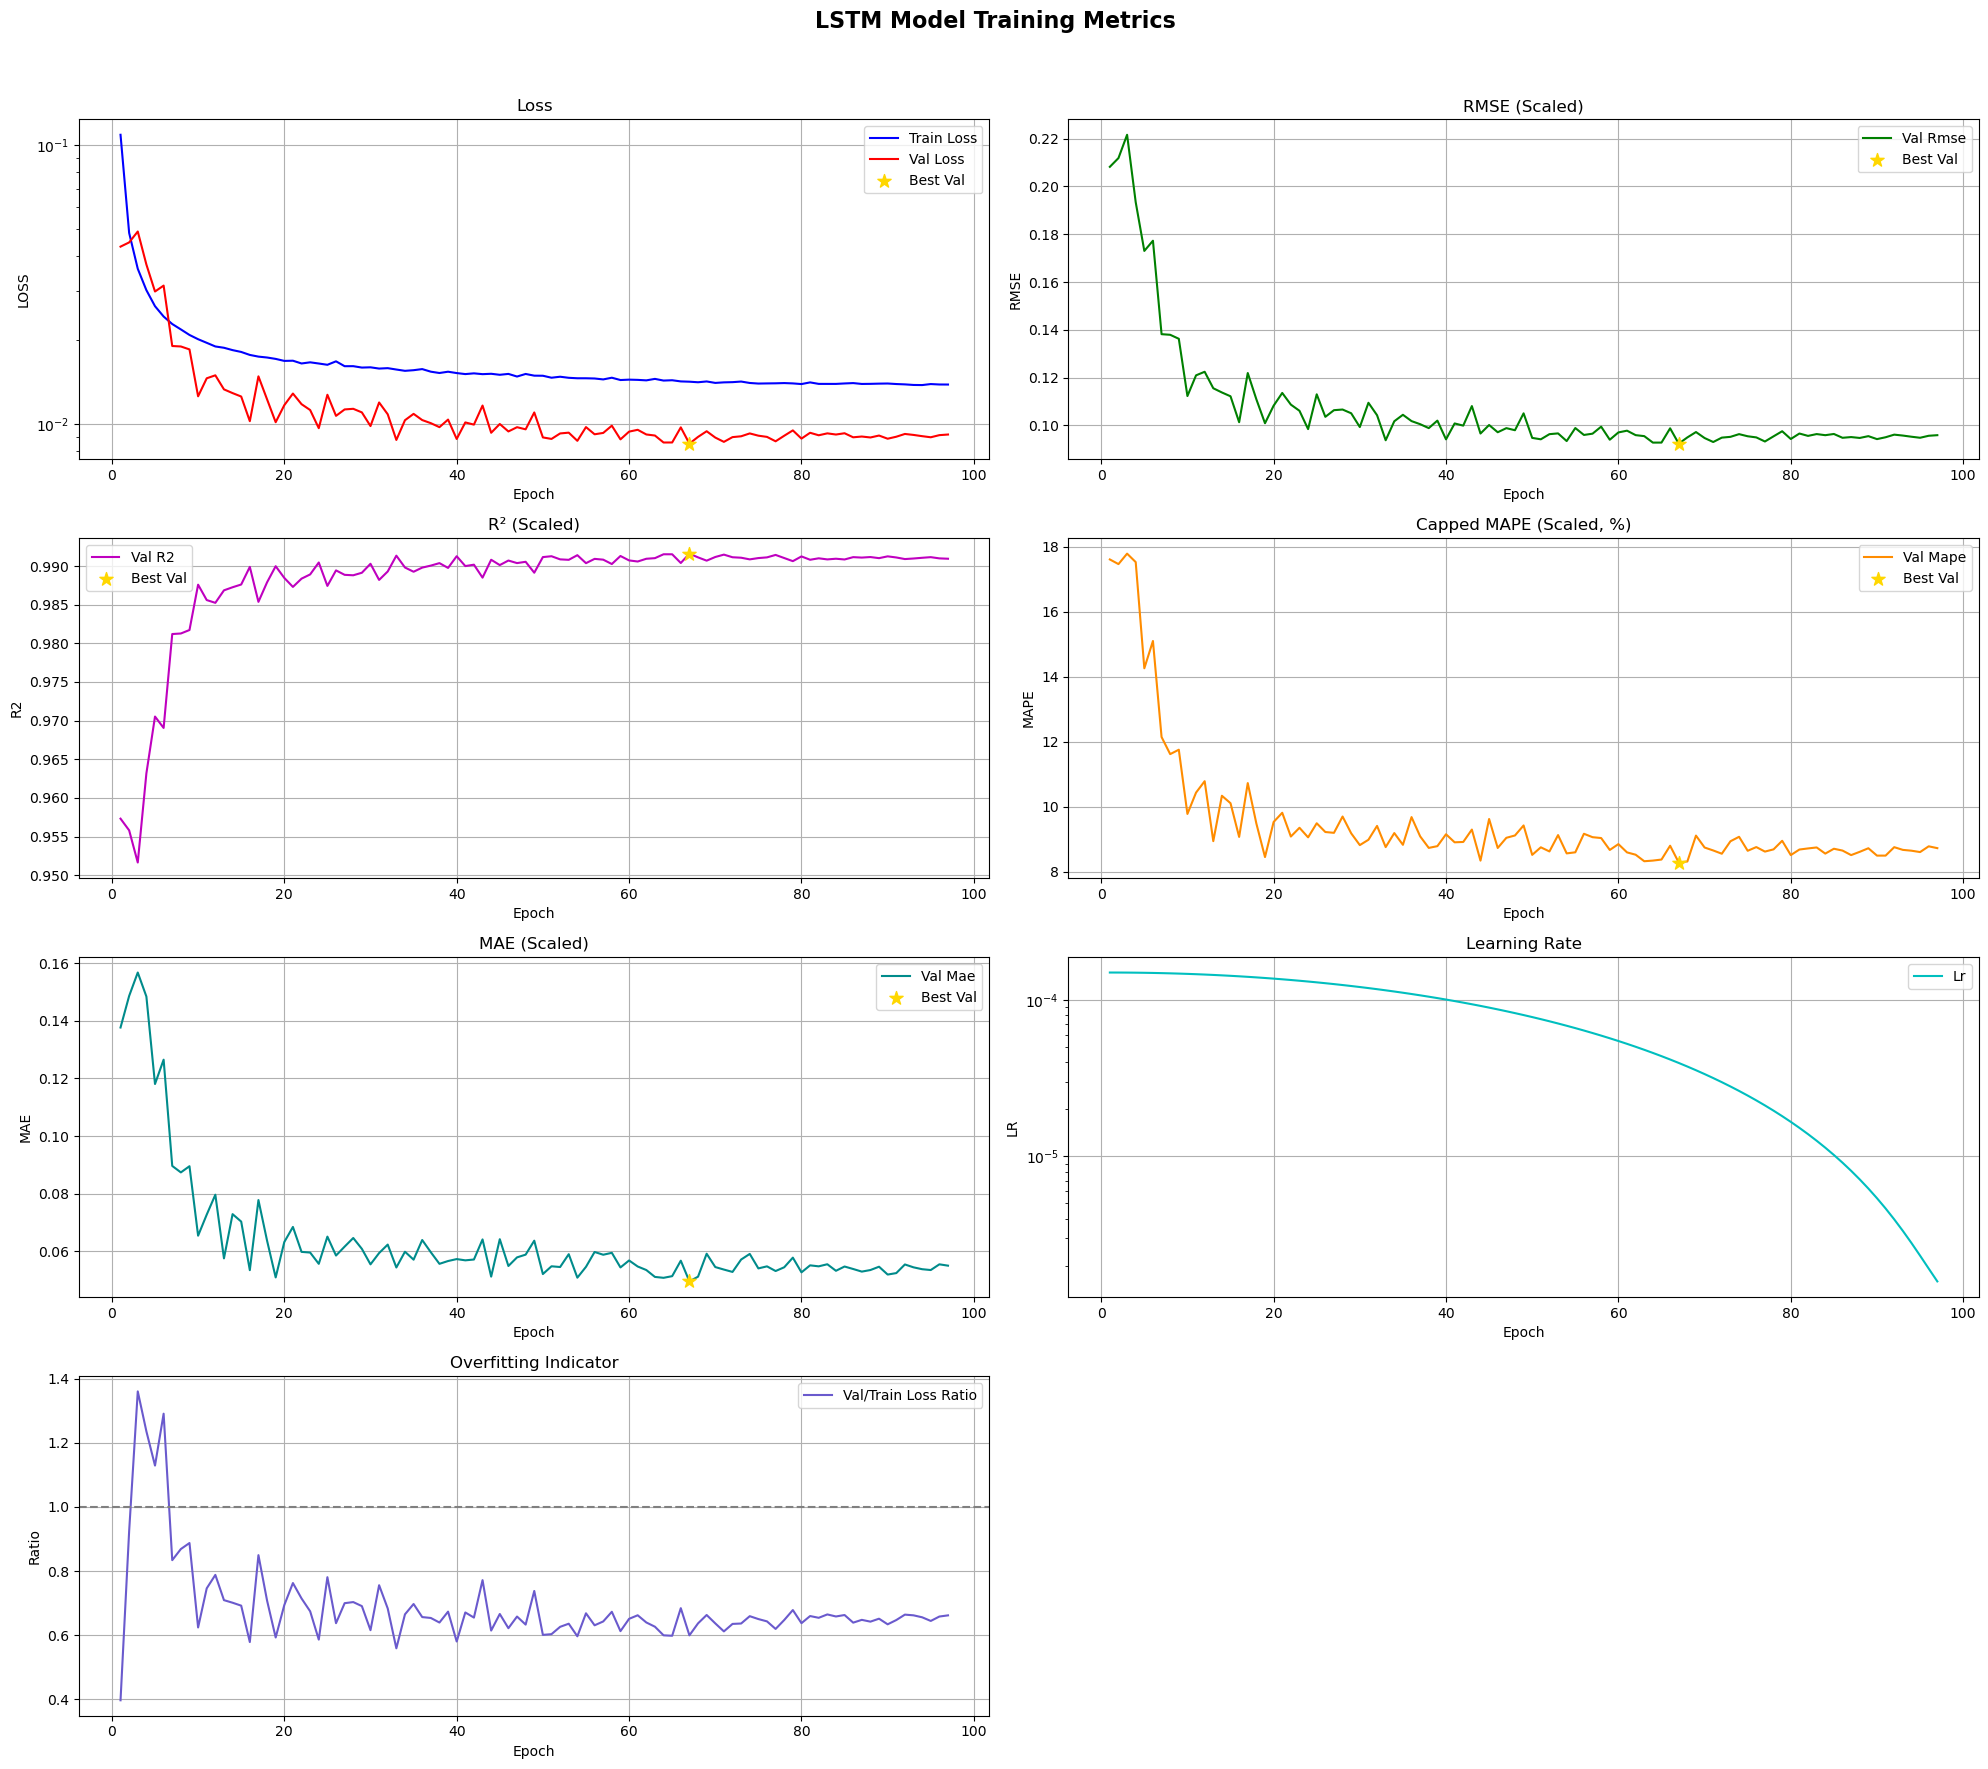

In [42]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()
model.transform_info = full_transform_details  # Store the whole transform_info object

In [48]:


logging.info("Evaluating model on test data...")
try:
    # Evaluate on test data using the refactored method signature
    scaled_preds, scaled_actuals, original_preds, original_actuals, metrics_dict = model.evaluate(
        X_test_data=X_test,
        y_test_data=y_test,
        device=device,  # Pass the device
        target_scaler_object=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info_dict=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers,  # Pass the whole scalers dictionary
        batch_size=32,
        return_predictions=True,
        plot_results=True
    )

    # Access metrics directly from the returned dictionary
    if original_preds is not None and original_actuals is not None:
        logging.info(f"Test RMSE (original scale from metrics_dict): {metrics_dict.get('rmse', 'N/A'):.4f}")
        logging.info(f"Test MAE (original scale from metrics_dict): {metrics_dict.get('mae', 'N/A'):.4f}")
        logging.info(f"Test Capped MAPE (original scale from metrics_dict): {metrics_dict.get('mape_capped', 'N/A'):.2f}%")
        logging.info(f"Test R² (original scale from metrics_dict): {metrics_dict.get('r2', 'N/A'):.4f}")
    else:
        logging.warning("Original scale predictions/actuals were not generated, cannot report original scale metrics here.")

    logging.info(f"All scaled metrics: "
                 f"RMSE={metrics_dict.get('scaled_rmse', 'N/A'):.4f}, "
                 f"MAE={metrics_dict.get('scaled_mae', 'N/A'):.4f}, "
                 f"Capped MAPE={metrics_dict.get('scaled_mape_capped', 'N/A'):.2f}% "
                 f"R²={metrics_dict.get('scaled_r2', 'N/A'):.4f}")

except Exception as e:
    logging.error(f"Error during model evaluation: {e}", exc_info=True)




2025-06-06 20:32:50,337 - INFO - Evaluating model on test data...
2025-06-06 20:32:50,339 - ERROR - Error during model evaluation: evaluate() got an unexpected keyword argument 'batch_size'
Traceback (most recent call last):
  File "/var/folders/4q/4w3g7t5n0td3xk6v5zqfpp2w0000gn/T/ipykernel_21184/1904001431.py", line 4, in <module>
    scaled_preds, scaled_actuals, original_preds, original_actuals, metrics_dict = model.evaluate(
TypeError: evaluate() got an unexpected keyword argument 'batch_size'


In [14]:
if original_actuals is not None and original_preds is not None:
    logging.info("Generating residual and prediction vs. actual plots for original scale data...")
    
    # Calculate residuals in the original scale
    residuals_original = original_actuals.flatten() - original_preds.flatten()
    mean_residuals_original = np.mean(residuals_original)
    std_residuals_original = np.std(residuals_original)

    # --- 1. Frequency of Residuals (Histogram) in Original Scale ---
    plt.figure(figsize=(10, 6))
    plt.hist(residuals_original, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    plt.axvline(mean_residuals_original, color='red', linestyle='dashed', linewidth=2, 
                label=f'Mean Residual: {mean_residuals_original:.2f}')
    plt.title('Frequency of Residuals (Original Scale)', fontsize=16)
    plt.xlabel(f'Residual (Actual Value - Predicted Value) in original units', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.75)
    plt.text(0.95, 0.90, f'Std Dev of Residuals: {std_residuals_original:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=10)
    plt.show()

    # --- 2. Predictions vs. Actuals in Original Scale ---
    plt.figure(figsize=(10, 8))
    plt.scatter(original_actuals, original_preds, alpha=0.5, color='cornflowerblue', label='Predicted vs. Actual')
    
    # Determine plot limits for y=x line and observed trend
    min_val = min(np.min(original_actuals), np.min(original_preds))
    max_val = max(np.max(original_actuals), np.max(original_preds))
    
    # Ideal line (y=x)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')
    
    # Observed trend line (y = x - K', where K' is mean_residuals_original)
    # This line represents: predicted = actual - mean_residual
    plt.plot([min_val, max_val], 
             [min_val + mean_residuals_original, max_val + mean_residuals_original], 
             # Corrected: if residual = actual - predicted, then predicted = actual - residual.
             # So if K' = actual - predicted, then predicted = actual - K'.
             # The plot should be y (predicted) vs x (actual).
             # If mean_residuals_original > 0, model under-predicts on average, so predicted = actual - |K'|
             # If mean_residuals_original < 0, model over-predicts on average, so predicted = actual + |K'|
             # So, it's always predicted = actual - mean_residuals_original
             'g:', lw=2, 
             label=f'Observed Trend (y = x - K\')\n(K\' = Mean Residual = {mean_residuals_original:.2f})')
             
    plt.title('Predictions vs. Actuals (Original Scale)', fontsize=16)
    plt.xlabel('Actual Values (Original Units)', fontsize=12)
    plt.ylabel('Predicted Values (Original Units)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.5)
    plt.axis('equal') 
    plt.show()

else:
    logging.warning("Could not generate plots because original_actuals or original_preds is None.")

NameError: name 'original_actuals' is not defined

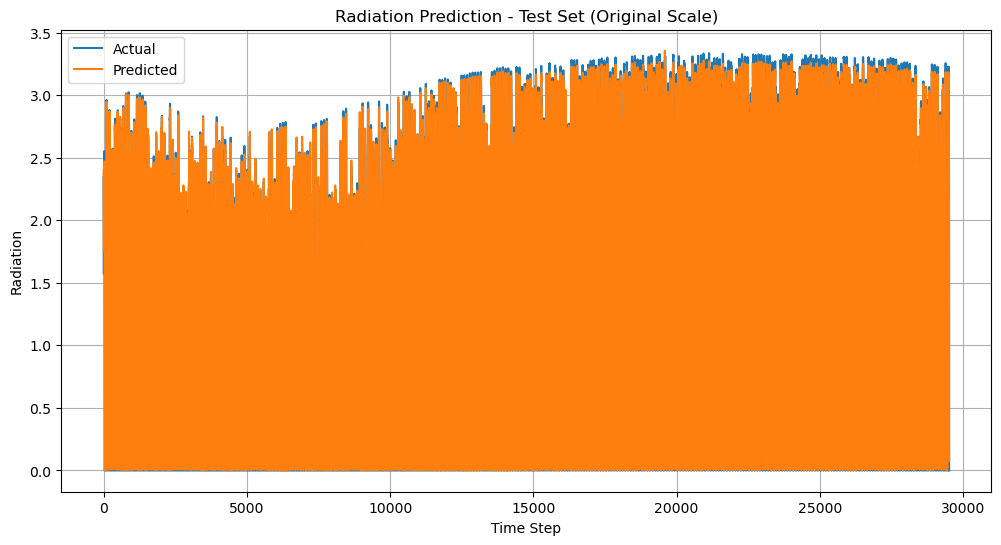

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals, label='Actual')
plt.plot(original_preds, label='Predicted')
plt.title('Radiation Prediction - Test Set (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df["GHI"].max()

229.2

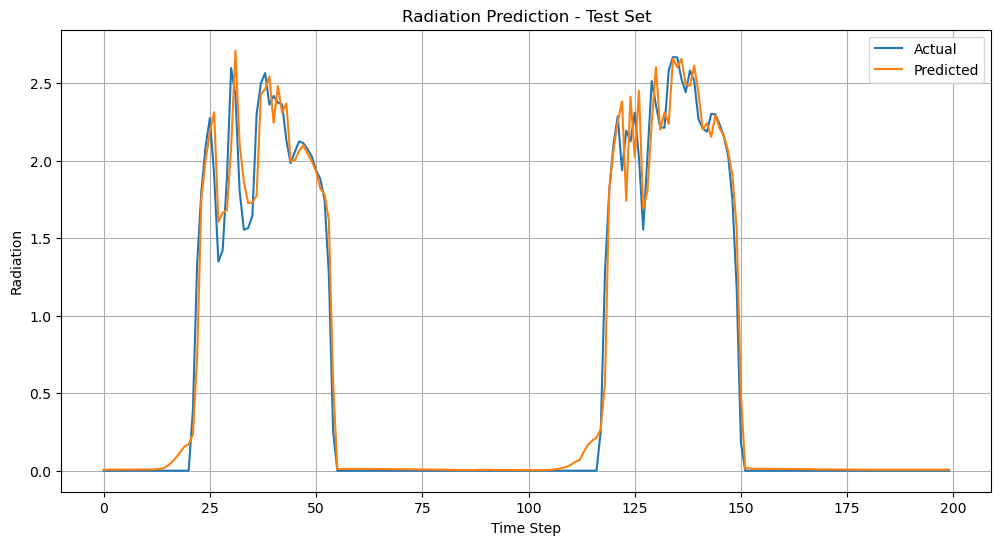

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(original_actuals[2950:3150], label='Actual')
plt.plot(original_preds[2950:3150], label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pred_with_uncertainty = model.predict_with_uncertainty(X_test[0:100], mc_samples=30,        
        target_scaler=scalers.get(full_transform_details.get('target_scaler_name')), # Get the specific target scaler
        transform_info=full_transform_details, # This should be the output from data_prep
        scalers_dict=scalers,
        device = device)  # Pass the whole scalers dictionary)

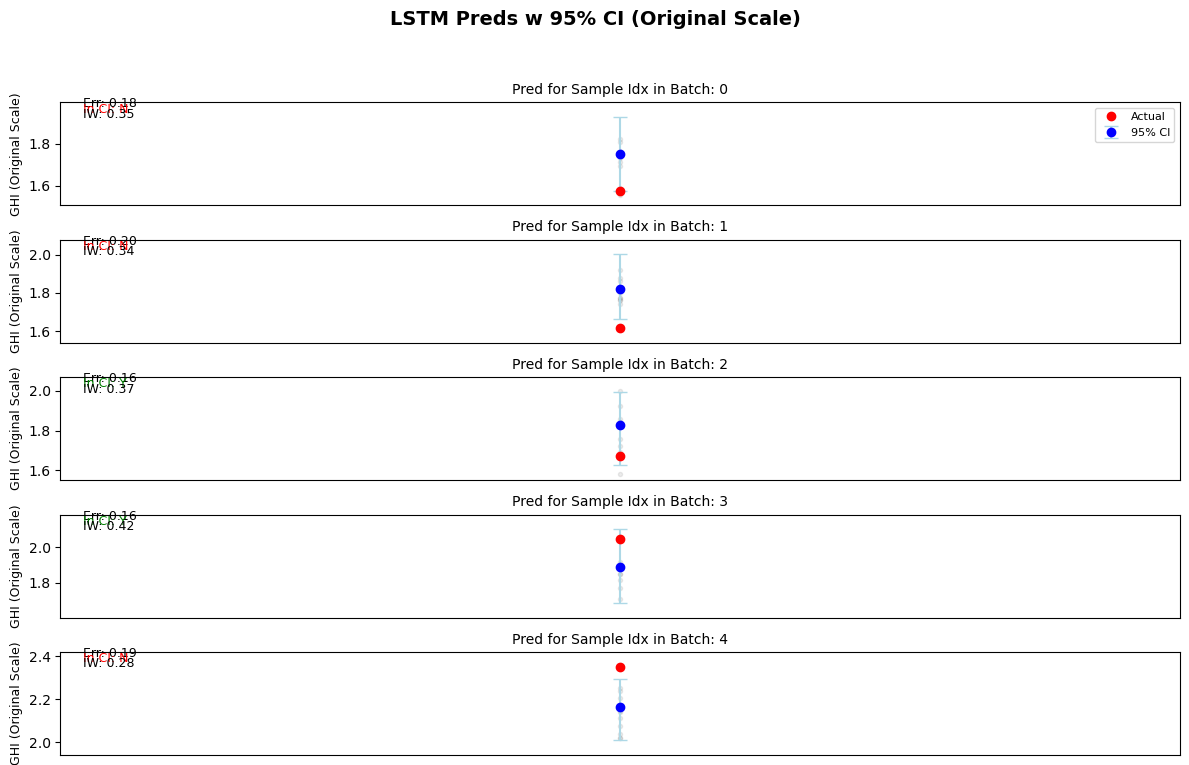

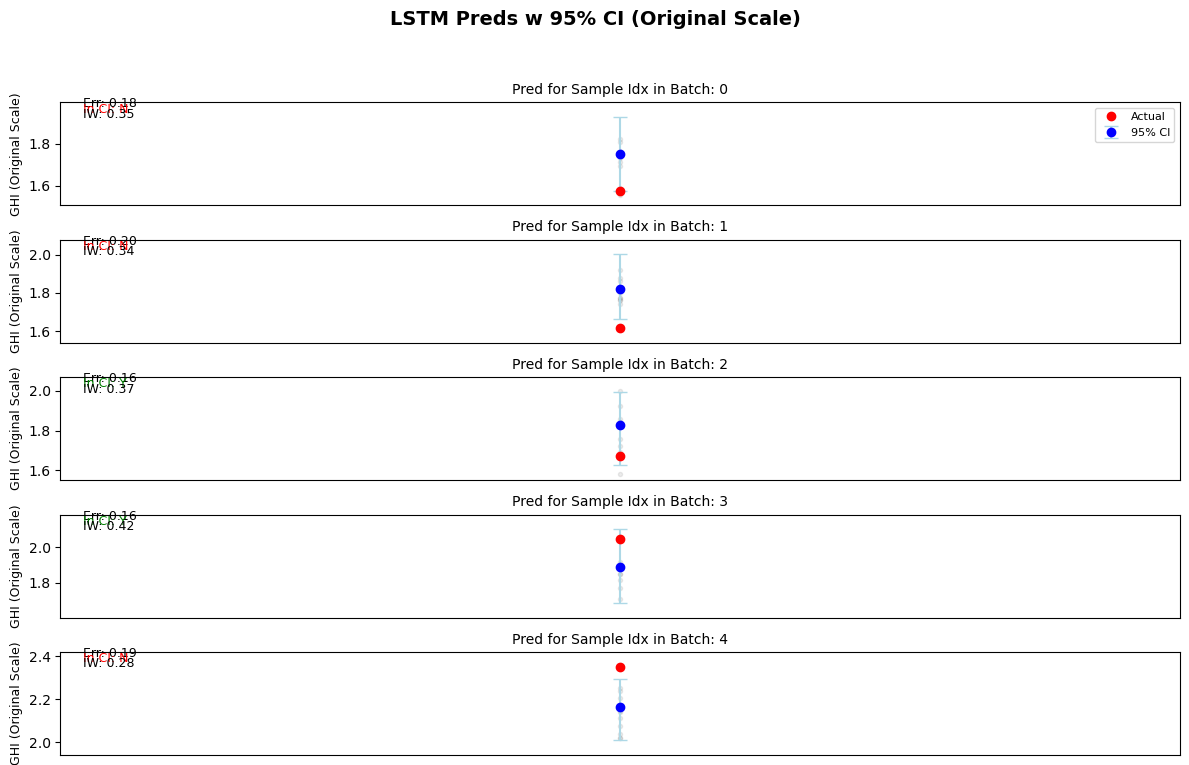

In [23]:
model.plot_prediction_with_uncertainty(X_test[0:100],y_test[0:100],mc_samples=30, 
                                       target_scaler=scalers.get(full_transform_details.get('target_scaler_name')),
                                       transform_info=full_transform_details, # This should be the output from data_prep
                                        scalers_dict=scalers,
                                        device = device,
                                        max_samples_to_plot = 5)


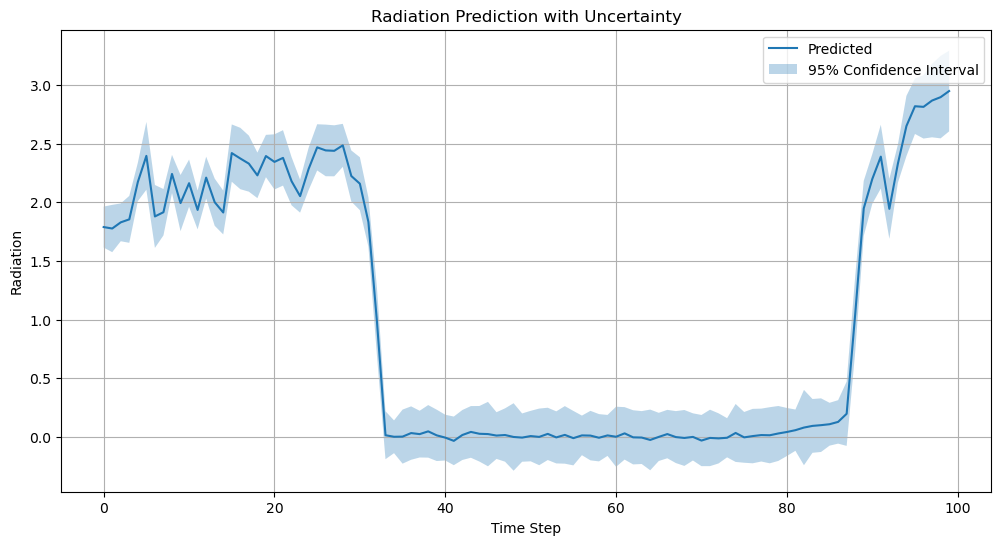

In [22]:
# plot uncertainty
plt.figure(figsize=(12, 6))
plt.plot(pred_with_uncertainty['mean'].squeeze(), label='Predicted')
plt.fill_between(range(len(pred_with_uncertainty['std'])), 
                 (pred_with_uncertainty['mean'] - 1.96 * pred_with_uncertainty['std']).squeeze(),
                 (pred_with_uncertainty['mean'] + 1.96 * pred_with_uncertainty['std']).squeeze(),
                 alpha=0.3, label='95% Confidence Interval')
plt.title('Radiation Prediction with Uncertainty')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
print(model.fc3.bias.item())
print(model.fc3.weight)


0.05188759043812752
Parameter containing:
tensor([[ 0.0440,  0.0779,  0.0657, -0.1508,  0.0867,  0.0483, -0.1137, -0.0989,
         -0.1305, -0.1771, -0.1345, -0.0787, -0.1681,  0.0413,  0.0677,  0.0932,
          0.0642, -0.2249, -0.1253, -0.0663,  0.0851,  0.0687,  0.0626, -0.1275,
         -0.1040,  0.1189, -0.1228,  0.0530, -0.0417, -0.1421, -0.0658, -0.1113,
         -0.0764,  0.0901,  0.0248, -0.0727,  0.0760,  0.0963,  0.0847,  0.0788,
          0.0533, -0.1137,  0.0575,  0.1734,  0.0216,  0.0386, -0.0894, -0.1245,
         -0.1394, -0.1412, -0.0945,  0.0420, -0.1333, -0.0939,  0.0621,  0.1086,
         -0.0506, -0.1381, -0.1390, -0.1117,  0.0327, -0.0649,  0.0585,  0.3722]],
       requires_grad=True)


In [ ]:
model.save('weather_lstm_model.pt')



# Weather Prediction LSTM Model: Technical Summary

## Model Architecture

The model utilizes a Long Short-Term Memory (LSTM) network. The specific structure of the `WeatherLSTM` network, based on the final trained model, is as follows:

**WeatherLSTM Network Structure:**<br>
┌─────────────────────────────────────────────────────┐<br>
│ ➤ LSTM Layer (19→256, layers=1, dropout=0.3)        │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (256→128)                   │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (128→64)                    │<br>
│ ➤ ReLU Activation                                   │<br>
│ ➤ Dropout Layer (p=0.3)                             │<br>
│ ➤ Fully Connected Layer (64→1)                      │<br>
└─────────────────────────────────────────────────────┘

## Core Parameters

  - **Input Dimension**: 19 features
  - **Hidden Dimension**: 256
  - **LSTM Layers**: 1
  - **Output Dimension**: 1 (predicting a single value, 'Radiation')
  - **Dropout Probability**: 0.3 (applied after the LSTM layer and after each ReLU activation in the fully connected block)
  - **Fully Connected Layers**: 256→128→64→1 with ReLU activations

## Dataset Structure

  - **Training Set**: X\_train shape: (118051, 24, 19), y\_train shape: (118051, 1)
  - **Validation Set**: X\_val shape: (49188, 24, 19), y\_val shape: (49188, 1)
  - **Test Set**: X\_test shape: (29513, 24, 19), y\_test shape: (29513, 1)
  - **Data Format**: Sequences of 24 timesteps, with 19 features per timestep.

## Loss Function

The model was trained using the Mean Squared Error (MSE) loss function:

$\\mathcal{L}*{MSE} = \\frac{1}{n}\\sum*{i=1}^{n}(y\_{true} - y\_{pred})^2$

(Note: The Optuna hyperparameter search explored a combined MSE and MAPE loss, but the final model training utilized MSE loss.)

## Regularization Techniques

  - **Dropout**: Probability of 0.3 applied after the LSTM layer and after each ReLU activation in the fully connected block.
  - **L2 Regularization**: Weight decay of $1 \\times 10^{-5}$ applied during training.
  - **Gradient Clipping**: Norm constrained to 1.0 to prevent exploding gradients.

## Optimization Strategy

  - **Optimizer**: Adam.
  - **Learning Rate**: $0.00015$ for the final training.
  - **Learning Rate Scheduler**: CosineAnnealingLR with $T\_{max}=100$.
  - **Patience for Early Stopping**: 30 epochs (though the final training ran for the full 100 epochs as per the log).

## Data Transformation

  - **Target Variable ('Radiation') Transformation**:
      - A floor of 0.0 was applied to 'Radiation' values before transformation.
      - Yeo-Johnson Power Transform applied to the 'Radiation' column (lambda = -0.1973). The transformed target is named 'Radiation\_yeo'.
      - The transformed target ('Radiation\_yeo') was then scaled using StandardScaler.
  - **Feature Scaling**: Input features were scaled using MinMaxScaler.
  - **Feature Engineering**:
      - 'SolarElevation': A proxy feature for solar elevation was added.
      - 'Radiation\_is\_low': A binary feature created with a threshold of 0.0 for the 'Radiation' value.
      - Redundant date/time features were removed if similar ones already existed (e.g., 'DaylightMinutes' removed if 'dayLength' present).

## Input Features

The model uses 19 features for prediction:

  - 'Humidity'
  - 'Pressure'
  - 'Radiation' (original)
  - 'Radiation\_is\_low'
  - 'SolarElevation'
  - 'Speed' (wind speed)
  - 'SunlightTime/daylength' (Daylight Position)
  - 'Temperature'
  - 'TimeMinutesCos' (Cyclical encoding of time)
  - 'TimeMinutesSin' (Cyclical encoding of time)
  - 'clouds\_all'
  - 'dayLength'
  - 'hour'
  - 'isSun' (IsDaylight)
  - 'month'
  - 'rain\_1h'
  - 'snow\_1h'
  - 'sunlightTime'
  - 'weather\_type'

## Key Performance Metrics (Test Set - Original Scale)

  - **RMSE (Root Mean Squared Error)**: 7.8630
  - **MAE (Mean Absolute Error)**: 3.5478
  - **R² (R-squared)**: 0.9791
  - **Correlation Coefficient**: 0.9914
  - **MAPE (Mean Absolute Percentage Error)**: Extremely high due to near-zero actual values.
  - **MAPE (capped at 100% error per point)**: 56.81%

## Error Distribution Analysis

The residuals (Actuals - Predictions) on the scaled test data show:

  - **Mean Residual**: 0.0028
  - **Std Dev of Residuals**: 0.0275
  - **Min/Max Residuals**: -0.1730 / 0.2808

The high uncapped MAPE on the original scale suggests the model may struggle with predictions when true radiation values are very close to zero. However, the R² value close to 1 and high correlation indicate a strong overall fit for the majority of the data points. The capped MAPE provides a more stable metric for percentage error in such cases.

This architecture, combined with the data preprocessing and regularization techniques, aims to capture the complex temporal patterns in weather data for accurate radiation prediction, demonstrating strong performance as indicated by the R² and correlation metrics.
